In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib
import pickle
from surprise import dump
from surprise import accuracy, Dataset, SVD, KNNBasic, BaselineOnly, Reader, NMF
from surprise.model_selection import cross_validate, train_test_split
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from pandas_profiling import ProfileReport
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
tqdm.pandas()

### <font color='#191970'> I Chargement des jeux de données</font>
#### <font color='#191970'>&#9630;   Concatenations des jeux de données clicks</font>

In [2]:
clicks = pd.read_csv('clicks/clicks_hour_000.csv')
for i in range(1,385):
    path = 'clicks/clicks_hour_'+str(i).rjust(3, '0')+'.csv'
    clicks_to_add = pd.read_csv(path)
    clicks = pd.concat([clicks,clicks_to_add])
clicks.reset_index(inplace=True, drop=True)

In [2]:
clicks = pd.read_csv('clicks.csv')

In [3]:
articles_metadata = pd.read_csv('articles_metadata.csv')
embeddings = pd.read_pickle(r'articles_embeddings.pickle')
print('shape of articles_metadata: ',articles_metadata.shape)
print('shape of clicks: ', clicks.shape)
print('shape of embeddings: ', embeddings.shape)

shape of articles_metadata:  (364047, 5)
shape of clicks:  (2988181, 12)
shape of embeddings:  (364047, 250)


#### <font color='#191970'>&#9630;   Transformation des dates</font>

In [4]:
def function(integer):
    return time.ctime(int(integer/1000))

articles_metadata['created_at_ts'] = articles_metadata['created_at_ts'].progress_apply(function)
articles_metadata['created_at_ts'] = pd.to_datetime(articles_metadata.created_at_ts)
clicks['session_start'] = clicks['session_start'].progress_apply(function)
clicks['click_timestamp'] = clicks['click_timestamp'].progress_apply(function)
clicks['session_start'] = pd.to_datetime(clicks.session_start)
clicks['click_timestamp'] = pd.to_datetime(clicks.click_timestamp)
clicks = clicks.sort_values(['user_id','click_timestamp'], ascending = [True,False])  # on ordonne les click par user_id et par ordre décroissant de click_timestamp
clicks.to_csv('clicks.csv', index_label=False)
articles_metadata.to_csv('articles_metadata_timed.csv', index_label=False)

100%|████████████████████████████████████████████████████████████████████| 2988181/2988181 [00:26<00:00, 111609.86it/s]


#### <font color='#191970'>&#9630;   PCA sur les embeddings des articles</font>

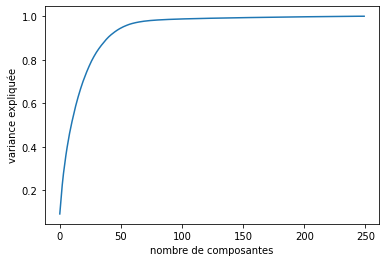

In [4]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
pca = PCA(n_components=embeddings.shape[1])
pca.fit(embeddings_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('nombre de composantes')
plt.ylabel('variance expliquée');

In [5]:
for i, j in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if j>.95:
        print(f'Avec {i} composantes, la variance expliquée est de {j*100} %')
        break

Avec 52 composantes, la variance expliquée est de 95.16950039141304 %


In [6]:
scaler_ = StandardScaler()
embeddings_scaled_ = scaler_.fit_transform(embeddings)
pca = PCA(n_components=52)
embeddings_pca = pca.fit_transform(embeddings_scaled_)

pd.DataFrame(data=embeddings_pca).to_csv('embeddings_pca.csv')
embeddings_scaled = pd.read_csv('embeddings_pca.csv')
embeddings_scaled.columns =  embeddings_scaled.columns.str.replace('Unnamed: 0', 'article_id')

### <font color='#191970'> II Content Based Filtering</font>
#### <font color='#191970'>&#9630;   Dernier article cliqué par un utilisateur</font>

In [7]:
latest_article = clicks[['user_id', 'click_timestamp','click_article_id']].groupby('user_id').agg({'click_timestamp':'first', 'click_article_id':'first'})

In [8]:
def dernier_article(user_id):
    #print(f"le dernier article lu par l'utilisateur d'identifiant {user_id} a pour code {latest_article.iloc[user_id][1]}")
    return latest_article.iloc[user_id][1]

#### <font color='#191970'>&#9630;   Liste des articles lus par un utilisateur</font>

In [9]:
liste_articles_lus = clicks.groupby('user_id').agg(liste_des_articles = ('click_article_id', lambda x: list(x)))

In [10]:
def liste_des_articles_lus(user_id):
    return list(set(liste_articles_lus.iloc[user_id][0]))

#### <font color='#191970'>&#9630;   DataFrame des embeddings d'articles non lus par un utilisateur</font>

In [11]:
print(f"Il existe au total {articles_metadata['article_id'].nunique()} articles et nous avons {embeddings_scaled.shape[0]} embbedings d'articles")

Il existe au total 364047 articles et nous avons 364047 embbedings d'articles


In [12]:
def df_des_articles_non_lus_par_un_utilisateur(user_id):
    return embeddings_scaled.drop(liste_des_articles_lus(user_id))

In [13]:
def meilleurs_recommendations(user_id):
    liste_mesure_cosine = []
    x_0 = df_des_articles_non_lus_par_un_utilisateur(user_id)
    y = np.array(embeddings_scaled.loc[dernier_article(user_id)][1:].values)
    norm_y = np.linalg.norm(y)
    for i in range(364047-len(liste_des_articles_lus(user_id))):
        x = np.array(x_0.iloc[i][1:].values) 
        norm_x = np.linalg.norm(x)
        dot_product = np.linalg.norm(np.dot(x,y)/(norm_x*norm_y))
        liste_mesure_cosine.append(dot_product)
    df_result = pd.DataFrame(data={'mesure':liste_mesure_cosine}, index=df_des_articles_non_lus_par_un_utilisateur(user_id).index)
    result = df_result.sort_values('mesure', ascending=True)[:5]
    print(f"Au dernier article d'identifiant {dernier_article(user_id)} lu par l'utilisateur {user_id}, on recommande les articles suivants: ")
    return result

In [40]:
%%time
meilleurs_recommendations(1000)

Au dernier article d'identifiant 123757 lu par l'utilisateur 1000, on recommande les articles suivants: 
CPU times: total: 46.1 s
Wall time: 48.3 s


,mesure
207989,5.434552e-07
304273,1.442133e-06
193307,2.155320e-06
206797,2.867090e-06
201923,3.784134e-06


### <font color='#191970'> III Collaborative Filtering</font>

Le Collaborative Filtering repose sur l'analyse du rating des articles par les utilisateurs. Ici pour faire simple, on établira le rating comme le nombre de fois qu'un utilisateur a cliqué sur un article. Pour se faire, regroupons les utilisateurs par leur identifiant 'user_id'. Puis, on considère qu'un article a été lu si il existe une session pour laquelle cet article apparait. Faisons un nouveau regroupement sur les 'articles_id' et comptons les 'session_id' pour chacun d'eux.

#### <font color='#191970'>&#9630;   Réagencement des données pour la librairie SURPRISE</font>

In [12]:
df_collaborative = pd.read_csv('clicks.csv')

In [13]:
mini_df = df_collaborative[['user_id','click_article_id','session_id']]
mini_df = mini_df.groupby(by=['user_id','click_article_id'],  as_index = False).agg('count')
mini_df.rename(columns={"user_id": "userId", "click_article_id": "articleId", "session_id": "clicks"}, inplace=True)
mini_df.columns = ['userID', 'articles', 'clicks']

In [15]:
mini_df.to_csv('mini_df.csv', index_label=False)

In [17]:
mini_dff = pd.read_csv('mini_df.csv')

In [18]:
mini_dff.head()

,userID,articles,clicks
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1


In [6]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[['userID', 'articles', 'clicks']], reader)
#trainset = data.build_full_trainset()
#trainset, testset = train_test_split(data, test_size=0.25)

#### <font color='#191970'>&#9630;   SVD</font>

In [33]:
algo_svd = SVD()
result_svd = cross_validate(algo_svd, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1347  0.1366  0.1394  0.1369  0.0019  
MAE (testset)     0.0375  0.0375  0.0374  0.0375  0.0001  
Fit time          23.07   23.51   24.53   23.70   0.61    
Test time         11.31   8.37    11.47   10.38   1.42    


#### <font color='#191970'>&#9630;   NMF</font>

In [36]:
algo_nmf = NMF()
result_nmf = cross_validate(algo_nmf, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1523  0.1488  0.1473  0.1495  0.0021  
MAE (testset)     0.0725  0.0722  0.0725  0.0724  0.0002  
Fit time          53.20   53.64   52.07   52.97   0.66    
Test time         20.60   17.40   15.85   17.95   1.98    


#### <font color='#191970'>&#9630;   BaselineOnly</font>

In [40]:
algo_BO = BaselineOnly()
result_BO = cross_validate(algo_BO, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1284  0.1357  0.1297  0.1313  0.0032  
MAE (testset)     0.0260  0.0262  0.0260  0.0261  0.0001  
Fit time          9.75    10.39   10.36   10.17   0.29    
Test time         19.17   9.48    9.12    12.59   4.65    


#### <font color='#191970'>&#9630;   SVDpp</font>

In [39]:
algo_svdpp = SVDpp()
result_svdpp = cross_validate(algo_svdpp, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1345  0.1373  0.1280  0.1333  0.0039  
MAE (testset)     0.0298  0.0298  0.0297  0.0297  0.0000  
Fit time          65.00   68.62   70.80   68.14   2.39    
Test time         93.10   95.94   110.39  99.81   7.57    


### <font color='#191970'> IV Comparaison des modèles et temps des predictions individuelles</font>

In [10]:
def recommend_items(uid,topn=5, algo=SVD()):
    """
    prend en entrée le user _id et renvoie les tops recommendataion
    """
    iid_to_ignore=set(df.loc[df.userID==uid].articles)
    items2pred=pd.DataFrame(set(df.articles)-iid_to_ignore,columns=['articles'])
    items2pred['pred']=items2pred['articles'].apply(lambda x:algo.predict(uid=uid, iid=x)[3])
    if topn==0:
        recommendations_df=items2pred.loc[:,['articles','pred']].sort_values(by='pred', ascending=False)
    else:
        recommendations_df=items2pred.loc[:,['articles','pred']].sort_values(by='pred', ascending=False).head(topn)
    result = list(recommendations_df.index)
    resultat = ""
    for i in range(5): 
        if i != 4:
            resultat += str(result[i]) + ", "
        else:
            resultat += str(result[i]) 
                  
    return resultat

In [47]:
%%time
recommendation_svd = recommend_items(2546,5,algo_svd)

CPU times: total: 484 ms
Wall time: 528 ms


In [48]:
%%time
recommendation_nmf = recommend_items(2546,5,algo_nmf)

CPU times: total: 469 ms
Wall time: 488 ms


In [49]:
%%time
recommendation_BO = recommend_items(2546,5,algo_BO)

CPU times: total: 391 ms
Wall time: 430 ms


In [50]:
%%time
recommendation_svdpp = recommend_items(2546,5,algo_svdpp)

CPU times: total: 1 s
Wall time: 1.03 s


On constate qu'en terme de temps et de précision, l'algorithme BaselineOnly est le plus rapide et le plus performant. Essayons de tuner ses hyperparamètres pour le rendre encore plus performant.

### <font color='#191970'> V Tunning du modèle BaselineOnly</font>

In [12]:
#param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
# bsl_options = {"method": "als", "n_epochs": 5, "reg_u": 12, "reg_i": 5}
param_grid = {
    'bsl_options': {
        'method': ['als', 'sgd'],  # méthode pour effectuer la decomposition matricielle
        'reg': [1, 2],
        'n_epochs': [5,10]
    }
}

gs = GridSearchCV(BaselineOnly, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
0.13115496077600572
{'bsl_options': {'method': 'als', 'reg': 1, 'n_epochs': 10}}


In [13]:
bsl_options = {"method": "als", "n_epochs": 10, "reg": 1}
algo_azure = BaselineOnly(bsl_options=bsl_options)

In [14]:
result_azure = cross_validate(algo_azure, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1280  0.1358  0.1298  0.1312  0.0033  
MAE (testset)     0.0261  0.0261  0.0260  0.0261  0.0000  
Fit time          9.72    10.36   10.37   10.15   0.30    
Test time         7.86    7.24    7.06    7.39    0.34    


In [16]:
trainset = data.build_full_trainset()
algo_azure.fit(trainset)

Estimating biases using als...


In [45]:
# save the knn_model to disk
filename = 'model_azure.sav'
pickle.dump(algo_azure, open(filename, 'wb'))

In [46]:
# load the model from disk
filename = 'model_azure.sav'
model_reloaded = pickle.load(open(filename, 'rb'))

In [65]:
recommendation_modele_charge = recommend_items(2546,5,model_reloaded)

In [66]:
recommendation_modele_charge

'25786, 38551, 40400, 27811, 36312'